# Data

In [1]:
%ls DS-Unit-2-Applied-Modeling/data/my-datasets/

bankruptcy.csv  solar-radiation.csv


In [2]:
filepath = 'DS-Unit-2-Applied-Modeling/data/my-datasets/bankruptcy.csv'

# Wrangling

In [3]:
import pandas as pd
import numpy as np

In [4]:
#Multicolinearity
useless = ['Current Liabilities/Liability',
 'Current Liability to Assets',
 'Current Liability to Equity',
 'Debt ratio %',
 'Operating Gross Margin',
 'Net Value Per Share (A)',
 'No-credit Interval',
 'Net Value Per Share (B)',
 'Borrowing dependency',
 'Operating Profit Growth Rate',
 'Net Income to Total Assets',
 'Pre-tax net Interest Rate',
 'Gross Profit to Sales',
 'Net worth/Assets',
 'Operating Profit Rate',
 'Inventory and accounts receivable/Net value',
 'Retained Earnings to Total Assets',
 'Working Capital/Equity',
 "Net Income to Stockholder's Equity",
 'ROA(B) before interest and depreciation after tax',
 'Working Capital to Total Assets',
 'Total Asset Return Growth Rate Ratio',
 'Inventory/Working Capital',
 'Operating profit/Paid-in capital',
 'Cash Flow to Liability',
 'Realized Sales Gross Margin',
 'Persistent EPS in the Last Four Seasons',
 'Per Share Net profit before tax (Yuan ¥)',
 'Interest Coverage Ratio (Interest expense to EBIT)',
 'Current Liabilities/Equity',
 'Cash flow rate',
 'Liability to Equity',
 'Cash Flow to Equity',
 'ROA(A) before interest and % after tax',
 'Cash Flow Per Share',
 'Continuous Net Profit Growth Rate',
 'Cash Flow to Total Assets',
 'Net profit before tax/Paid-in capital',
 'Operating profit per person',
 'ROA(C) before interest and depreciation before interest',
 'Regular Net Profit Growth Rate',
 'After-tax Net Profit Growth Rate',
 'Cash Reinvestment %',
 'Operating Funds to Liability',
 'CFO to Assets',
 'After-tax net Interest Rate',
 'Cash Flow to Sales']

#Less Than Zero Permuted Importance
useless += ['Quick Assets/Current Liability',
 'Revenue Per Share (Yuan ¥)',
 'Operating Expense Rate',
 'Long-term fund suitability ratio (A)',
 'Quick Assets/Total Assets',
 'Long-term Liability to Current Assets',
 'Inventory/Current Liability',
 'Net Worth Turnover Rate (times)']

#Remove Duplicates
useless = list( dict.fromkeys(useless) )

In [5]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    drop_cols = useless
    
    #Format Column Names
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace('capitcal', 'Capital')
    
    #Single Value Columns
    drop_cols.append('Net Income Flag')
    
    #Nearly Single Value (over 99.9% zeros)
    drop_cols.append('Liability-Assets Flag')
    
    df = df.drop(columns=drop_cols)

    return df

df = wrangle(filepath)

# Target Vector and Feature Matrix

In [6]:
target = 'Bankrupt?'
y = df[target]
X = df.drop(columns=target)

In [7]:
print('Rows: %i \nColumns: %i' % X.shape)

Rows: 6819 
Columns: 38


# Remove Multicolinear Columns

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [9]:
vif_info = pd.DataFrame([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                        index = X.columns, columns = ['VIF']).sort_values(
                            by='VIF', ascending=False)

In [75]:
multicolinear_cols = []

while vif_info['VIF'][0] > 5:
    multicolinear_cols.append(vif_info.index[0])
    X = X.drop(columns = [ vif_info.index[0] ])
    print('%s removed' % vif_info.index[0])
    vif_info = pd.DataFrame([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                        index = X.columns, columns = ['VIF']).sort_values(
                            by='VIF', ascending=False)
if len(multicolinear_cols) > 0:
    print("Drop These Columns in the Wrangle Function:")
    display(multicolinear_cols)
else:
    print('No Multicolinearity Detected')

No Multicolinearity Detected


# Statified Split for Testing

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train_and_val, X_test, y_train_and_val, y_test = (
    train_test_split(X, y,test_size=0.2, stratify=y, random_state=42))

n_minority_tav = (y_train_and_val==1).sum()
n_total_tav = y_train_and_val.shape[0]

n_minority_test = (y_test==1).sum()
n_total_test = y_test.shape[0]

print('Train and Validate: %i Bankruptcies out of %i Companies, %0.2f%% of Total' %
      ( n_minority_tav, n_total_tav, n_minority_tav/n_total_tav*100 ) )
print('Test: %i Bankruptcies out of %i Companies, %0.2f%% of Total' %
      ( n_minority_test, n_total_test, n_minority_test/n_total_test*100 ) )

Train and Validate: 176 Bankruptcies out of 5455 Companies, 3.23% of Total
Test: 44 Bankruptcies out of 1364 Companies, 3.23% of Total


# Stratified K-Fold Splits for Cross Validation

In [13]:
from sklearn.model_selection import StratifiedKFold

In [14]:
skf = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=42)

# Over Sampler for Training Sets

In [15]:
from imblearn.over_sampling import BorderlineSMOTE

In [16]:
over_sampler = BorderlineSMOTE(sampling_strategy='auto',
                     random_state=42,
                     n_jobs=-1)

# Everything Is Fine

In [17]:
import warnings
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Evaluation Metrics

In [18]:
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.model_selection import cross_validate

In [19]:
ap_scorer = make_scorer(average_precision_score, greater_is_better=True)

In [20]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
def CV_Results(model):
    cv_results = cross_validate(model,
                               X_train_and_val,
                               y_train_and_val,
                               scoring=ap_scorer)
    mean = cv_results['test_score'].mean()
    std = cv_results['test_score'].std()
    
    return (mean, std)

# Estimators and Pipelines

In [21]:
from imblearn.pipeline import make_pipeline

In [22]:
##################
num_trees_rf = 200
##################

##################
num_trees_xgb = 100
##################

## Logistic Regression (Baseline)

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [24]:
lr = LogisticRegression(
    n_jobs=-1,
    max_iter=1000)

In [79]:
model_lr = make_pipeline(
    StandardScaler(),
    over_sampler,
    lr
)

In [80]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
print('Cross Validation Results for Logistic Regression Baseline')
print()
print(' Average Precision Score = %f +/- %f' %  CV_Results(model_lr) )

Cross Validation Results for Logistic Regression Baseline

 Average Precision Score = 0.144575 +/- 0.019676


## Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
rf = RandomForestClassifier(
    n_jobs = 2,
    random_state = 42,
    n_estimators = num_trees_rf
)

In [29]:
model_rf = make_pipeline(
    over_sampler,
    rf
)

In [30]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
print('Cross Validation Results for Random Forest Classifier')
print()
print(' Average Precision Score = %f +/- %f' %  CV_Results(model_rf) )

Cross Validation Results for Random Forest Classifier

 Average Precision Score = 0.170052 +/- 0.056227


## XG Boost Classifier

In [31]:
from xgboost import XGBClassifier

In [32]:
xgb = XGBClassifier(
    n_jobs = -1,
    random_state = 42,
    use_label_encoder=False,
    eval_metric = 'aucpr',
    n_estimators = num_trees_xgb
)

In [33]:
model_xgb = make_pipeline(
    over_sampler,
    xgb
)

In [34]:
print('Cross Validation Results for XG Boost Classifier')
print()
print(' Average Precision Score = %f +/- %f' %  CV_Results(model_xgb) )

Cross Validation Results for XG Boost Classifier

 Average Precision Score = 0.202266 +/- 0.079579


# Hyperparameter Tuning for AP Score

In [35]:
from sklearn.model_selection import RandomizedSearchCV

In [36]:
###########################################################################
tune_rf = True
n_iter_rf = 200
param_dict_rf = {
    'borderlinesmote__kind': ['borderline-1', 'borderline-2'],
    'borderlinesmote__m_neighbors': [5, 10, 25, 50, 80],
    'borderlinesmote__k_neighbors': [5, 10, 25, 50, 80],
    'randomforestclassifier__max_depth': range(5,20),
    'randomforestclassifier__max_features': range(5,20),
    'randomforestclassifier__min_samples_split': range(5,40)
}
###########################################################################

###########################################################################
tune_xgb = True
n_iter_xgb = 200
param_dict_xgb = {
    'borderlinesmote__kind': ['borderline-1', 'borderline-2'],
    'borderlinesmote__m_neighbors': [5, 10, 25, 50, 80],
    'borderlinesmote__k_neighbors': [5, 10, 25, 50, 80],
    'xgbclassifier__learning_rate': np.linspace(0.1, 0.5, 20),
    'xgbclassifier__max_depth': range(3,9),
    'xgbclassifier__subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'xgbclassifier__colsample_bytree': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
}
###########################################################################

In [37]:
def Random_Search(model,params,n_iter):
    rand_search = RandomizedSearchCV(
        estimator = model,
        param_distributions = params,
        scoring = ap_scorer,
        cv = skf,
        n_iter = n_iter,
        n_jobs = -1,
    )
    rand_search.fit(X_train_and_val, y_train_and_val)
    
    results = pd.DataFrame(rand_search.cv_results_).sort_values(by='rank_test_score')
    best_score_mean = results['mean_test_score'][0]
    best_score_std = results['std_test_score'][0]
    best_estimator = rand_search.best_estimator_
    best_params = rand_search.best_params_
    
    return best_score_mean, best_score_std, best_estimator, best_params

## Random Forest  Tuning

In [38]:
if tune_rf:
    ap_mean_rf, ap_std_rf, best_rf, params_rf = Random_Search(
        model_rf, param_dict_rf, n_iter_rf
    )
    print('Cross Validation Results for Random Forest after Tuning')
    print(' Best Average Precision Score: %0.8f +/- %0.8f' % (ap_mean_rf, ap_std_rf) )
    print(' Using The Randomized Parameters:')
    display(params_rf)
else:
    best_rf = model_rf
    ap_mean_rf, ap_std_rf = CV_Results(model_rf)
    params_rf = {}

Cross Validation Results for Random Forest After Tuning
 Best Average Precision Score: 0.20916875 +/- 0.02568776
 Using The Randomized Parameters:


{'randomforestclassifier__min_samples_split': 8,
 'randomforestclassifier__max_features': 6,
 'randomforestclassifier__max_depth': 11,
 'borderlinesmote__m_neighbors': 10,
 'borderlinesmote__kind': 'borderline-1',
 'borderlinesmote__k_neighbors': 50}

## XG Boost Tuning

In [81]:
if tune_xgb:
    ap_mean_xgb, ap_std_xgb, best_xgb, params_xgb = Random_Search(
        model_xgb, param_dict_xgb, n_iter_xgb
    )
    print('Cross Validation Results for Random Forest after Tuning')
    print(' Best Average Precision Score: %0.8f +/- %0.8f' % (ap_mean_xgb, ap_std_xgb) )
    print(' Using The Randomized Parameters:')
    display(params_xgb)
else:
    best_xgb = model_xgb
    ap_mean_xgb, ap_std_xgb = CV_Results(model_xgb)
    params_xgb = {}

KeyboardInterrupt: 

# Threshold Tuning for F2 Score

In [40]:
from sklearn.metrics import precision_recall_curve

In [41]:
def Optimal_Thresholds(model):
    thresholds = []
    f2_scores = []
    recall_scores = []
    precision_scores = []
    
    for train_ind, val_ind in skf.split(X_train_and_val, y_train_and_val):
        #Train and Validation Splits
        X_train, y_train = X_train_and_val.iloc[train_ind], y_train_and_val.iloc[train_ind]
        X_val, y_val = X_train_and_val.iloc[val_ind], y_train_and_val.iloc[val_ind]
        
        #Fit Model
        model.fit(X_train, y_train)
        
        #Precision-Recall Curve Values
        pred_proba = model.predict_proba(X_val)[:,1]
        precision, recall, threshold = precision_recall_curve(
        y_true = y_val, probas_pred = pred_proba)
        
        #F2 Score Calculations and Sorting
        precision_recall = pd.DataFrame( {'Precision': precision[:-1],
                                     'Recall': recall[:-1],
                                     'Threshold': threshold})
        precision_recall['F2'] = ( (1.0+2**2)*precision_recall['Precision']
                                *precision_recall['Recall']/
                                (2**2*precision_recall['Precision']
                                 +precision_recall['Recall']) )
        precision_recall = precision_recall.sort_values(by='F2', ascending=False).fillna(0)
        
        #Values Corresponding to best F2 Score
        thresholds.append(precision_recall['Threshold'].iloc[0])
        precision_scores.append(precision_recall['Precision'].iloc[0])
        recall_scores.append(precision_recall['Recall'].iloc[0])
        f2_scores.append(precision_recall['F2'].iloc[0])
        
    #Calculated Weighted Averages and Weighted Standard Deviations
    threshold = np.average(thresholds, weights=f2_scores)
    threshold_std = np.sqrt(np.average((thresholds-threshold)**2, weights=f2_scores))
    recall = np.average(recall_scores, weights=f2_scores)
    recall_std = np.sqrt(np.average((recall_scores-recall)**2, weights=f2_scores))
    precision = np.average(precision_scores, weights=f2_scores)
    precision_std = np.sqrt(np.average((precision_scores-precision)**2, weights=f2_scores))
    f2 = np.average(f2_scores, weights=f2_scores)
    f2_std = np.sqrt(np.average((f2_scores-f2)**2, weights=f2_scores))
        
    return threshold,threshold_std,f2,f2_std,recall,recall_std,precision,precision_std

## Logistic Regression Threshold

In [42]:
threshold_lr, threshold_std_lr, f2_lr, f2_std_lr, recall_lr, recall_std_lr, precision_lr, precision_std_lr = (
    Optimal_Thresholds(model_lr))

print('Random Forest F2-Threshold Optimization')
print(" Threshold: %f +/- %f" % (threshold_lr, threshold_std_lr) )
print(" F2 Score: %f +/- %f" % (f2_lr, f2_std_lr) )
print(" Recall: %f +/- %f" % (recall_lr, recall_std_lr) )
print(" Precision: %f +/- %f" % (precision_lr, precision_std_lr) )

Random Forest F2-Threshold Optimization
 Threshold: 0.722819 +/- 0.082672
 F2 Score: 0.510334 +/- 0.022800
 Recall: 0.671081 +/- 0.048135
 Precision: 0.266190 +/- 0.035447


## Random Forest Threshold

In [43]:
threshold_rf, threshold_std_rf, f2_rf, f2_std_rf, recall_rf, recall_std_rf, precision_rf, precision_std_rf = (
    Optimal_Thresholds(best_rf))

print('Random Forest F2-Threshold Optimization')
print(" Threshold: %f +/- %f" % (threshold_rf, threshold_std_rf) )
print(" F2 Score: %f +/- %f" % (f2_rf, f2_std_rf) )
print(" Recall: %f +/- %f" % (recall_rf, recall_std_rf) )
print(" Precision: %f +/- %f" % (precision_rf, precision_std_rf) )

Random Forest F2-Threshold Optimization
 Threshold: 0.484413 +/- 0.075856
 F2 Score: 0.587472 +/- 0.043991
 Recall: 0.713589 +/- 0.067282
 Precision: 0.354625 +/- 0.057143


## XG Boost Threshold

In [44]:
threshold_xgb, threshold_std_xgb, f2_xgb, f2_std_xgb, recall_xgb, recall_std_xgb, precision_xgb, precision_std_xgb = (
    Optimal_Thresholds(best_xgb))

print('XG Boost F2-Threshold Optimization')
print(" Threshold: %f +/- %f" % (threshold_xgb, threshold_std_xgb) )
print(" F2 Score: %f +/- %f" % (f2_xgb, f2_std_xgb) )
print(" Recall: %f +/- %f" % (recall_xgb, recall_std_xgb) )
print(" Precision: %f +/- %f" % (precision_xgb, precision_std_xgb) )

XG Boost F2-Threshold Optimization
 Threshold: 0.153986 +/- 0.087597
 F2 Score: 0.579566 +/- 0.017928
 Recall: 0.709302 +/- 0.065892
 Precision: 0.354571 +/- 0.070831


# Testing

In [45]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, fbeta_score, roc_auc_score

In [46]:
def Test_Results(model, threshold):
    
    pred_proba = model.predict_proba(X_test)[:,1]
    predictions = pred_proba >= threshold
    
    auc = roc_auc_score(y_true=y_test, y_score=pred_proba)
    ap = average_precision_score(y_true=y_test, y_score=pred_proba)
    
    f2 = fbeta_score(y_true=y_test, y_pred=predictions,beta=2.0)
    recall = recall_score(y_true=y_test, y_pred=predictions)
    precision = precision_score(y_true=y_test, y_pred=predictions)
    accuracy = accuracy_score(y_true=y_test, y_pred=predictions)
    
    return ap, auc, f2, recall, precision, accuracy

## Save / Load Best Model

In [47]:
import pickle

In [48]:
equivalence_threshold = 0.0000001

In [49]:
def Update_Best_Model(model, f2_score, threshold):

    estimator_name = list(model.named_steps)[-1]
    saved_file = estimator_name + '.pickle'
    info_to_save = {
        "Model": model,
        "F2": f2_score,
        "Threshold": threshold,
        "Deleted Columns": useless
    }
    
    try:
        previous_model_info = pickle.load(open(saved_file, "rb"))
        if np.abs(previous_model_info['F2']-f2_score) < equivalence_threshold:
            status = {'Code': 1,
                      'Message': 'new model did not improve f2 score'}    
        elif previous_model_info['F2'] < f2_score:
            status = {'Code': 2,
                      'Message': ('best %s updated' % estimator_name)}
            pickle.dump(info_to_save, open(saved_file, "wb"))
        else:
            status = {'Code': 3,
                      'Message': 'new model has worse f2 score'}
        
    except (OSError, IOError) as e:
        previous_model_info = None
        status = {'Code': 4,
                      'Message': ('first %s model saved' % estimator_name)}
        pickle.dump(info_to_save, open(saved_file, "wb"))
        
    return previous_model_info, status

## Logistic Regression Test Results

In [50]:
ap_lr, auc_lr, f2_lr, recall_lr, precision_lr, acc_lr = Test_Results(model_lr, threshold_lr)
print('Test Results for Logistic Regression')
print(' AP Score: %f' % ap_lr)
print(' ROC AUC: %f' % auc_lr)
print()
print(' F2 Score: %f' % f2_lr)
print(' Recall: %f' % recall_lr)
print(' Precision: %f' % precision_lr)
print(' Accuracy: %f' % acc_lr)

Test Results for Logistic Regression
 AP Score: 0.273066
 ROC AUC: 0.877608

 F2 Score: 0.492958
 Recall: 0.636364
 Precision: 0.259259
 Accuracy: 0.929619


## Random Forest Test Results

In [89]:
ap_rf, auc_rf, f2_rf, recall_rf, precision_rf, acc_rf = Test_Results(best_rf, threshold_rf)

F2 Score:  0.5849056603773585


In [90]:
print("F2 Score: ", f2_rf)

dict_rf, status_rf = Update_Best_Model(best_rf, f2_rf, threshold_rf)

print(status_rf['Message']); print()

if status_rf['Code'] in [1,2,4]:
    print("No Saved Model Loaded")
elif (status_rf['Code'] == 3 and dict_rf['Deleted Columns'] == useless):
    print("Saved Model Reloaded")
    best_rf = dict_rf['Model']
    threshold_rf = dict_rf['Threshold']
    ap_rf, auc_rf, f2_rf, recall_rf, precision_rf, acc_rf = Test_Results(
        best_rf, threshold_rf)
    display(dict_rf)
elif status_rf['Code'] == 3:
    best_rf = dict_rf['Model']
    best_rf.fit(X_train_and_val, y_train_and_val)
    threshold_rf = dict_rf['Threshold']
    ap_rf, auc_rf, f2_rf, recall_rf, precision_rf, acc_rf = Test_Results(
        best_rf, threshold_rf)
    print(f2_rf)
    display(dict_rf)

F2 Score:  0.5849056603773585
new model did not improve f2 score

No Saved Model Loaded


In [53]:
print('Test Results for Best Random Forest')
print(' AP Score: %f' % ap_rf)
print(' ROC AUC: %f' % auc_rf)
print()
print(' F2 Score: %f' % f2_rf)
print(' Recall: %f' % recall_rf)
print(' Precision: %f' % precision_rf)
print(' Accuracy: %f' % acc_rf)

Test Results for Best Random Forest
 AP Score: 0.450332
 ROC AUC: 0.955269

 F2 Score: 0.584906
 Recall: 0.704545
 Precision: 0.348315
 Accuracy: 0.947947


## XG Boost Test Results

In [87]:
ap_xgb, auc_xgb, f2_xgb, recall_xgb, precision_xgb, acc_xgb = Test_Results(best_xgb, threshold_xgb)

In [88]:
print("F2 Score: ", f2_xgb)

dict_xgb, status_xgb = Update_Best_Model(best_xgb, f2_xgb, threshold_xgb)

print(status_xgb['Message']); print()

if status_xgb['Code'] in [1,2,4]:
    print("No Saved Model Loaded")
elif (status_xgb['Code'] == 3 and dict_xgb['Deleted Columns'] == useless):
    print("Saved Model Reloaded")
    best_xgb = dict_xgb['Model']
    threshold_xgb = dict_xgb['Threshold']
    ap_xgb, auc_xgb, f2_xgb, recall_xgb, precision_xgb, acc_xgb = Test_Results(
        best_xgb, threshold_xgb)
    display(dict_xgb)
elif status_xgb['Code'] == 3:
    best_xgb = dict_xgb['Model']
    best_xgb.fit(X_train_and_val, y_train_and_val)
    threshold_xgb = dict_xgb['Threshold']
    ap_xgb, auc_xgb, f2_xgb, recall_xgb, precision_xgb, acc_xgb = Test_Results(
        best_xgb, threshold_xgb)
    print(f2_xgb)
    display(dict_xgb)

F2 Score:  0.6021897810218978
new model did not improve f2 score

No Saved Model Loaded


In [91]:
print('Test Results for Best XG Boost')
print(' AP Score: %f' % ap_xgb)
print(' ROC AUC: %f' % auc_xgb)
print()
print(' F2 Score: %f' % f2_xgb)
print(' Recall: %f' % recall_xgb)
print(' Precision: %f' % precision_xgb)
print(' Accuracy: %f' % acc_xgb)

Test Results for Best XG Boost
 AP Score: 0.416568
 ROC AUC: 0.949389

 F2 Score: 0.602190
 Recall: 0.750000
 Precision: 0.336735
 Accuracy: 0.944282


# Test Result Visualizations

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

In [93]:
def Plot_Confusion_Matrix(model, threshold):
    fig, ax = plt.subplots(1, 1,figsize=(10,10))
    estimator_name = list(model.named_steps)[-1]
    ax.title.set_text('%s Confusion Matrix' % estimator_name.capitalize())
    ConfusionMatrixDisplay.from_predictions(
        y_true = y_test,
        y_pred = model.predict_proba(X_test)[:,1] >= threshold,
        display_labels=['Not Bankrupt', 'Bankrupt'],
        ax=ax,
        normalize='true')

In [94]:
def Plot_ROC_Curve(model, threshold, fig="", ax=""):
    if ax == "":
        fig, ax = plt.subplots(figsize=(20,10))
        ax.set_xlim([0.0001,1.0])
        ax.title.set_text('ROC')
    estimator_name = list(model.named_steps)[-1]
    RocCurveDisplay.from_predictions(
            y_true = y_test,
            y_pred = model.predict_proba(X_test)[:,1],
            name=estimator_name,
            ax=ax,
            pos_label = 1)
    return fig, ax

In [95]:
def Plot_PR_Curve(model, threshold, fig="", ax=""):
    if ax == "":
        fig, ax = plt.subplots(figsize=(20,10))
        ax.set_xlim([0.05,1.0])
        ax.title.set_text('Precision-Recall')
    estimator_name = list(model.named_steps)[-1]
    PrecisionRecallDisplay.from_predictions(
            y_true = y_test,
            y_pred = model.predict_proba(X_test)[:,1],
            name=estimator_name,
            ax=ax,
            pos_label = 1)
    return fig, ax

In [96]:
models = [model_lr, best_rf, best_xgb]
thresholds = [threshold_lr, threshold_rf, threshold_xgb]

## Confusion Matrices

### Logistic Regression Baseline

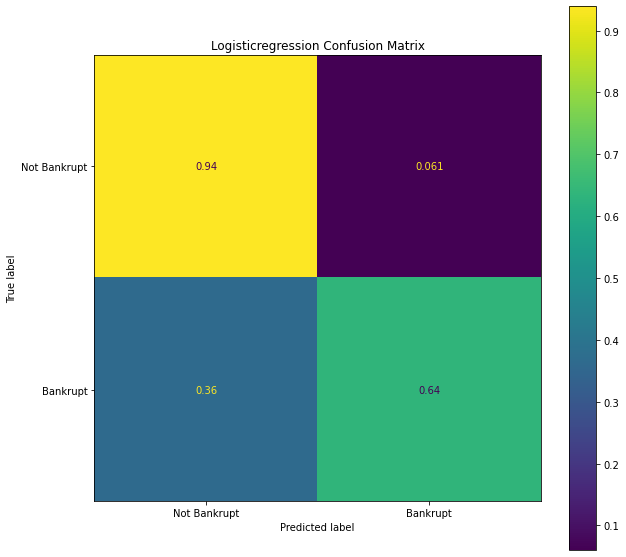

In [97]:
model_lr.fit(X_train_and_val, y_train_and_val)
Plot_Confusion_Matrix(model_lr, threshold_lr)

### Random Forest Classifier

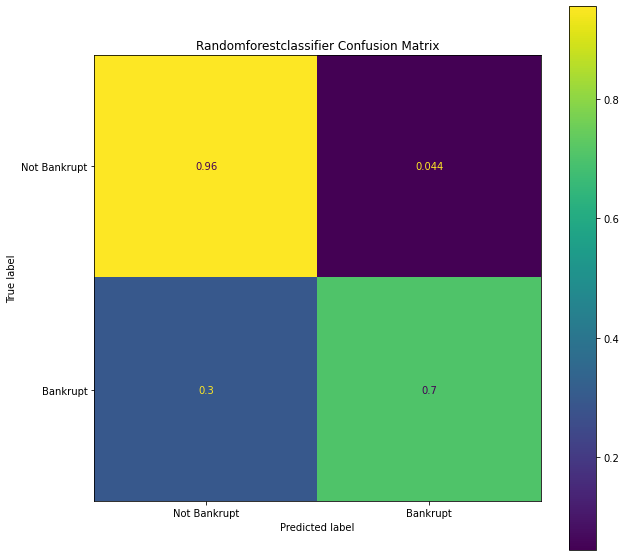

In [98]:
Plot_Confusion_Matrix(best_rf, threshold_rf)

### XG Boost Classifier

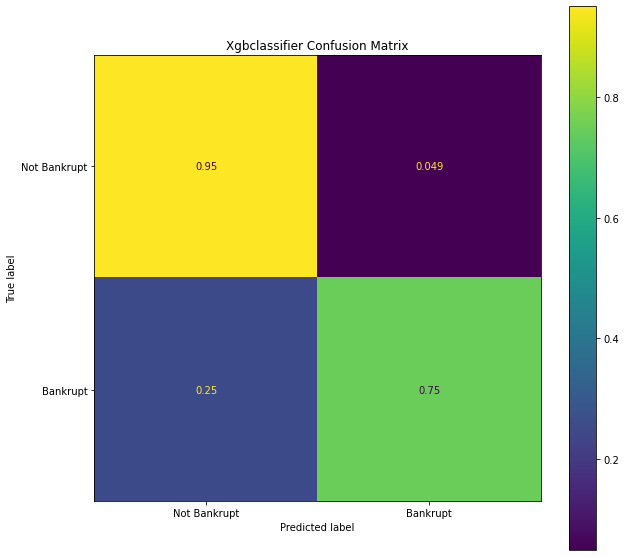

In [99]:
Plot_Confusion_Matrix(best_xgb, threshold_xgb)

## ROC Curves

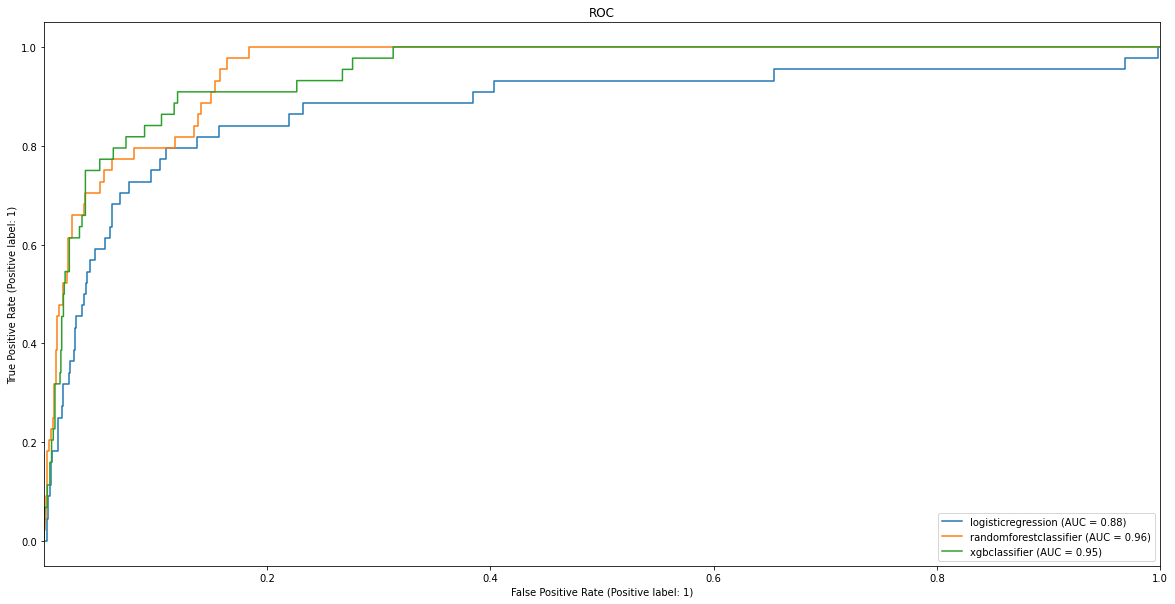

In [100]:
for i in range(len(models)):
    if i==0:
        fig, ax = Plot_ROC_Curve(models[i], thresholds[i])
    else:
        Plot_ROC_Curve(models[i], thresholds[i], fig, ax)

## Precision-Recall Curves

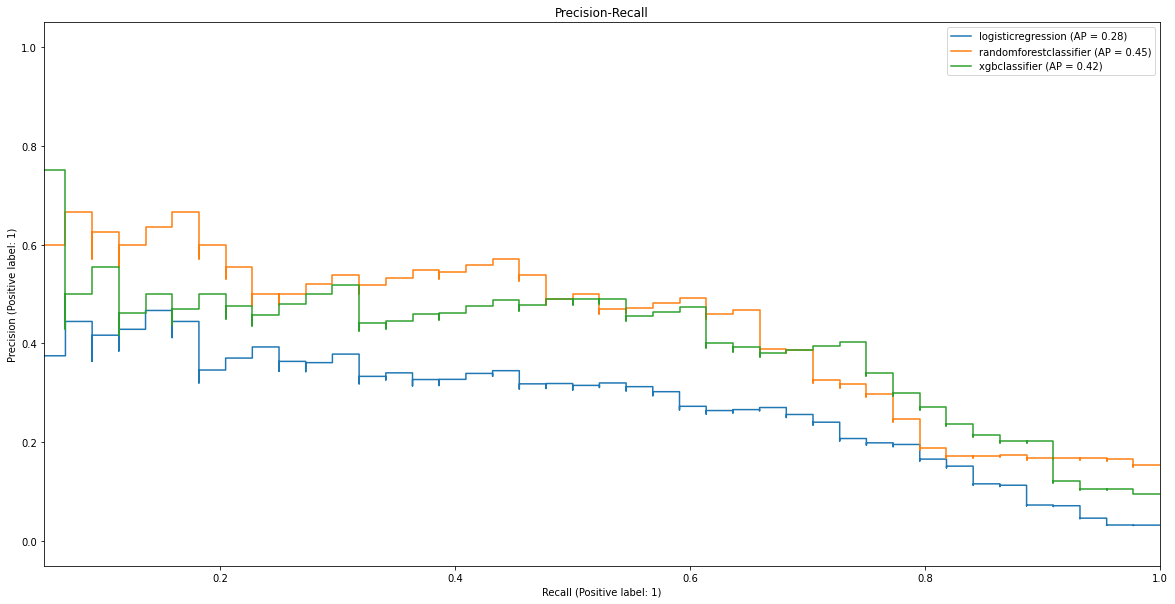

In [101]:
for i in range(len(models)):
    if i==0:
        fig, ax = Plot_PR_Curve(models[i], thresholds[i])
    else:
        Plot_PR_Curve(models[i], thresholds[i], fig, ax)
    ax.legend(loc="upper right")

# Permuted Feature Importances

In [102]:
from sklearn.inspection import permutation_importance
import seaborn as sns

In [103]:
def Permute_Features(model):
    mean_perm_imp = np.repeat(0.0, len(X_train_and_val.columns))
    for train_ind, val_ind in skf.split(X_train_and_val, y_train_and_val):
        
        #Train and Validation Splits
        X_train, y_train = X_train_and_val.iloc[train_ind], y_train_and_val.iloc[train_ind]
        X_val, y_val = X_train_and_val.iloc[val_ind], y_train_and_val.iloc[val_ind]
        
        #Fit to Training Split
        model.fit(X_train, y_train)
        
        #Find and Sort Importances
        perm_imp = permutation_importance(model, X_val, y_val, scoring=ap_scorer, n_repeats=20, n_jobs=-1)
        mean_perm_imp += perm_imp['importances_mean']
    
    mean_perm_imp /= skf.n_splits
    df_perm = pd.DataFrame(mean_perm_imp, index=X_val.columns, columns=['imp_mean']).sort_values(
        by='imp_mean', ascending=False)
        
    return df_perm

## Random Forest

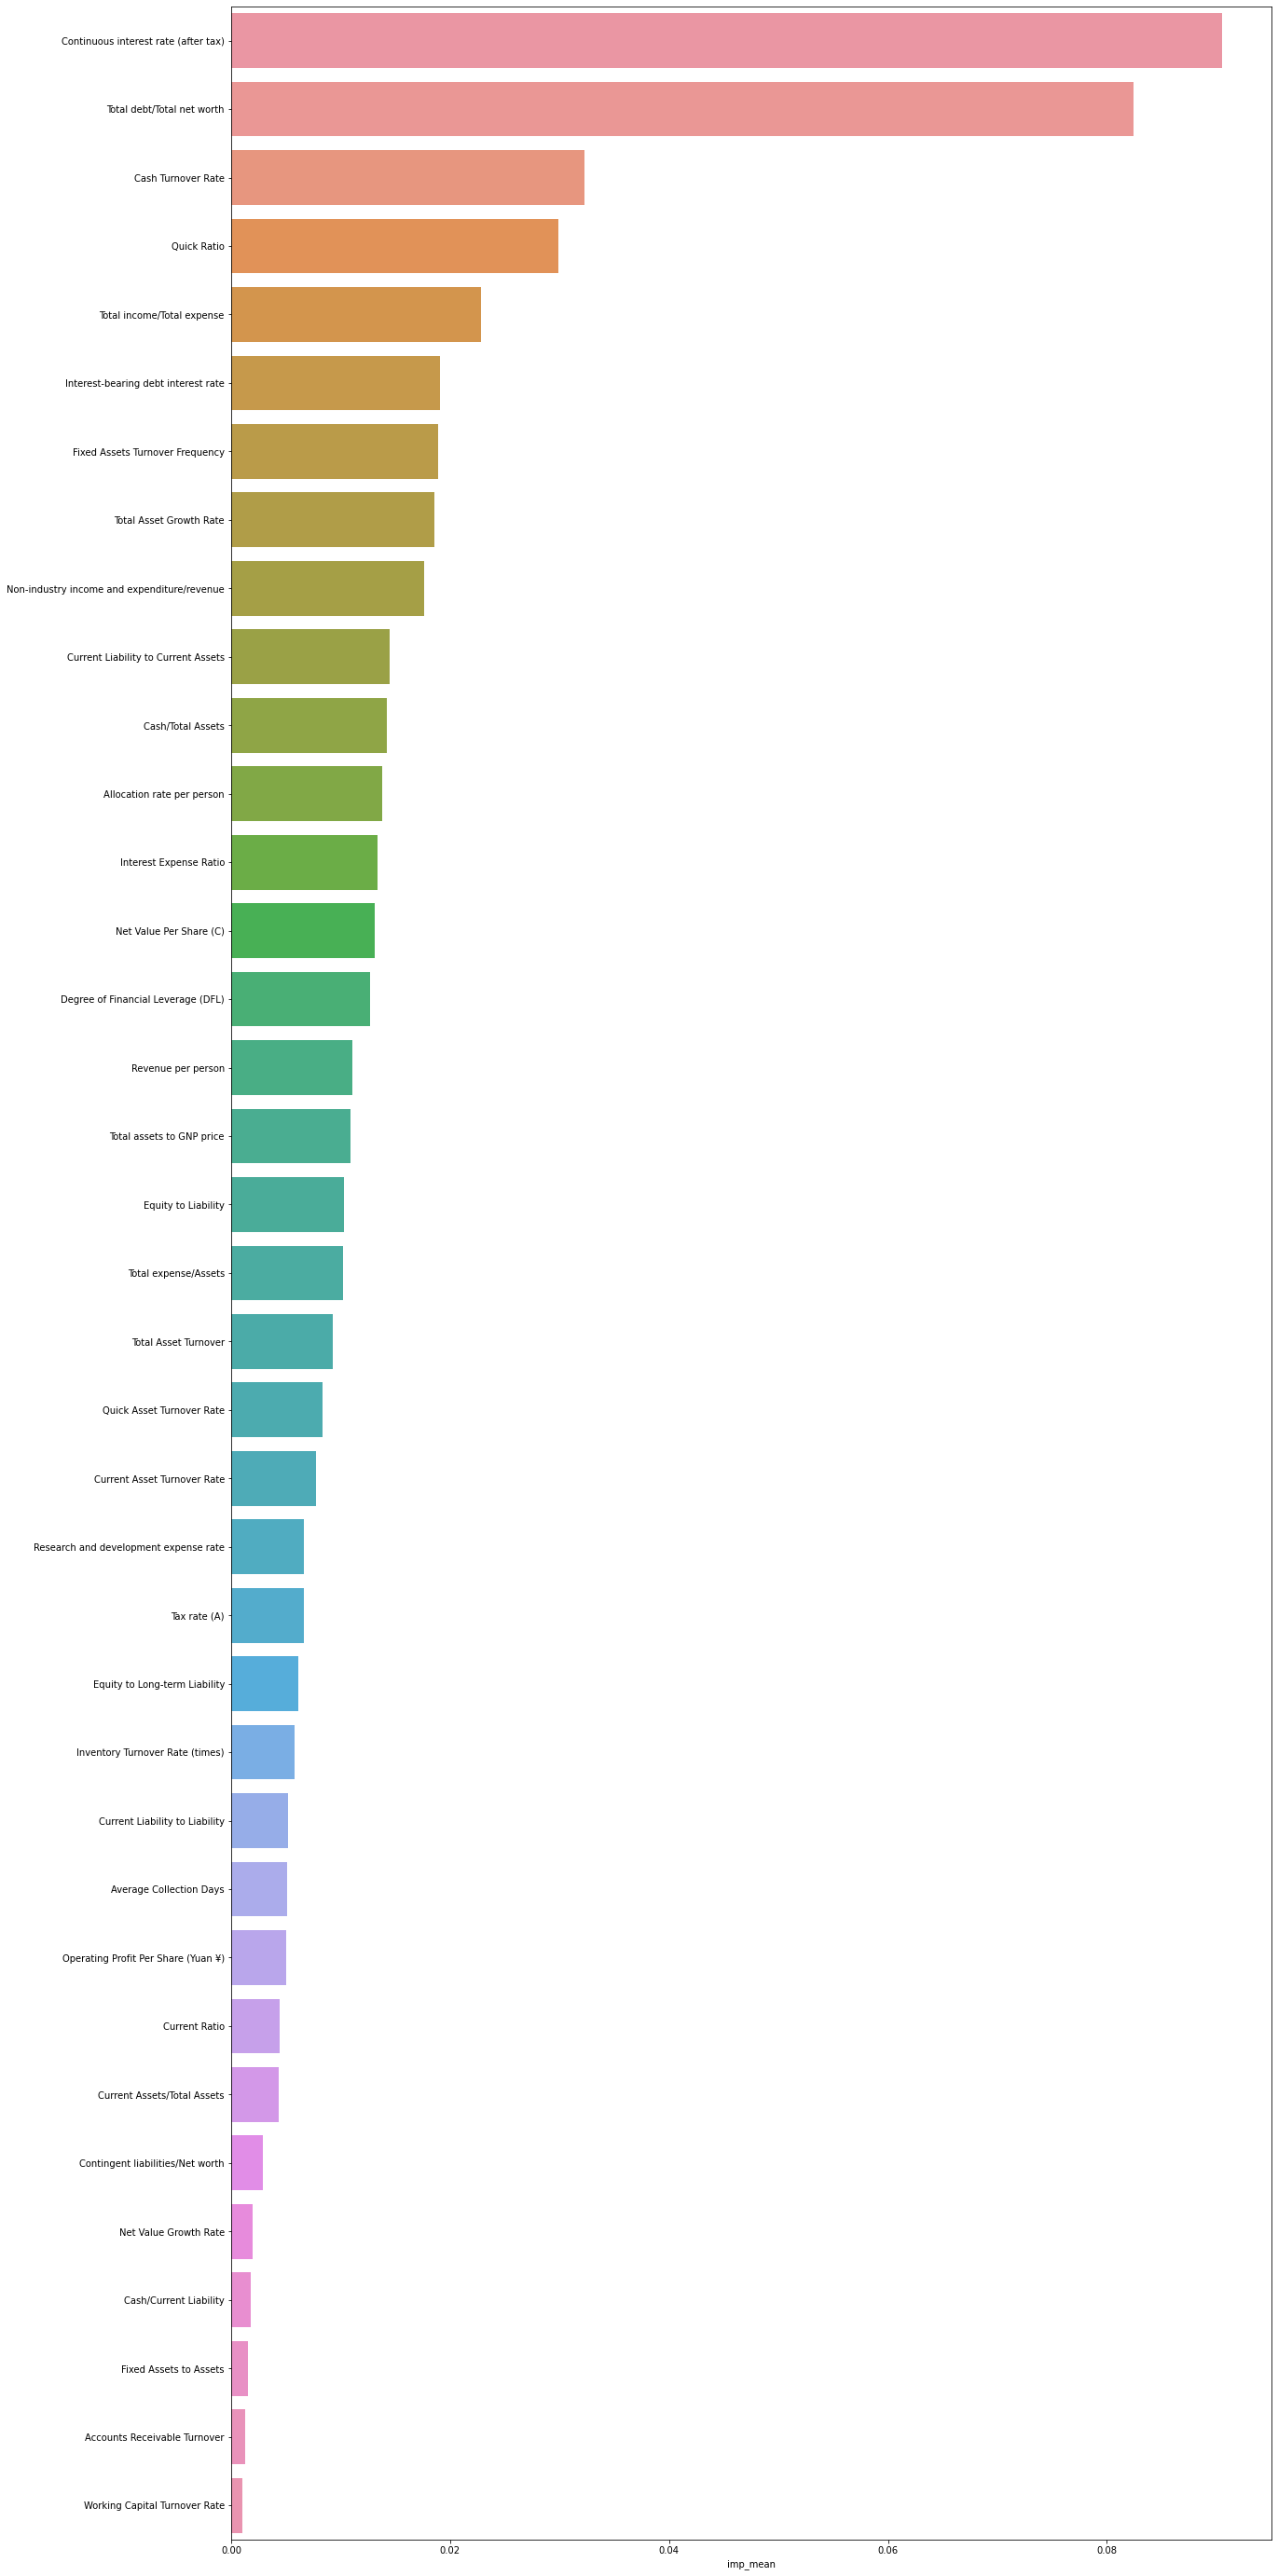

In [114]:
perm_rf = Permute_Features(best_rf)
worst_cols_rf = perm_rf.loc[ perm_rf['imp_mean'] <= 0 ]
perm_rf = perm_rf.loc[ perm_rf['imp_mean'] > 0 ]
plt.subplots(figsize=(20,50))
sns.barplot(x=perm_rf['imp_mean'], y=perm_rf.index, orient='h');

## XG Boost

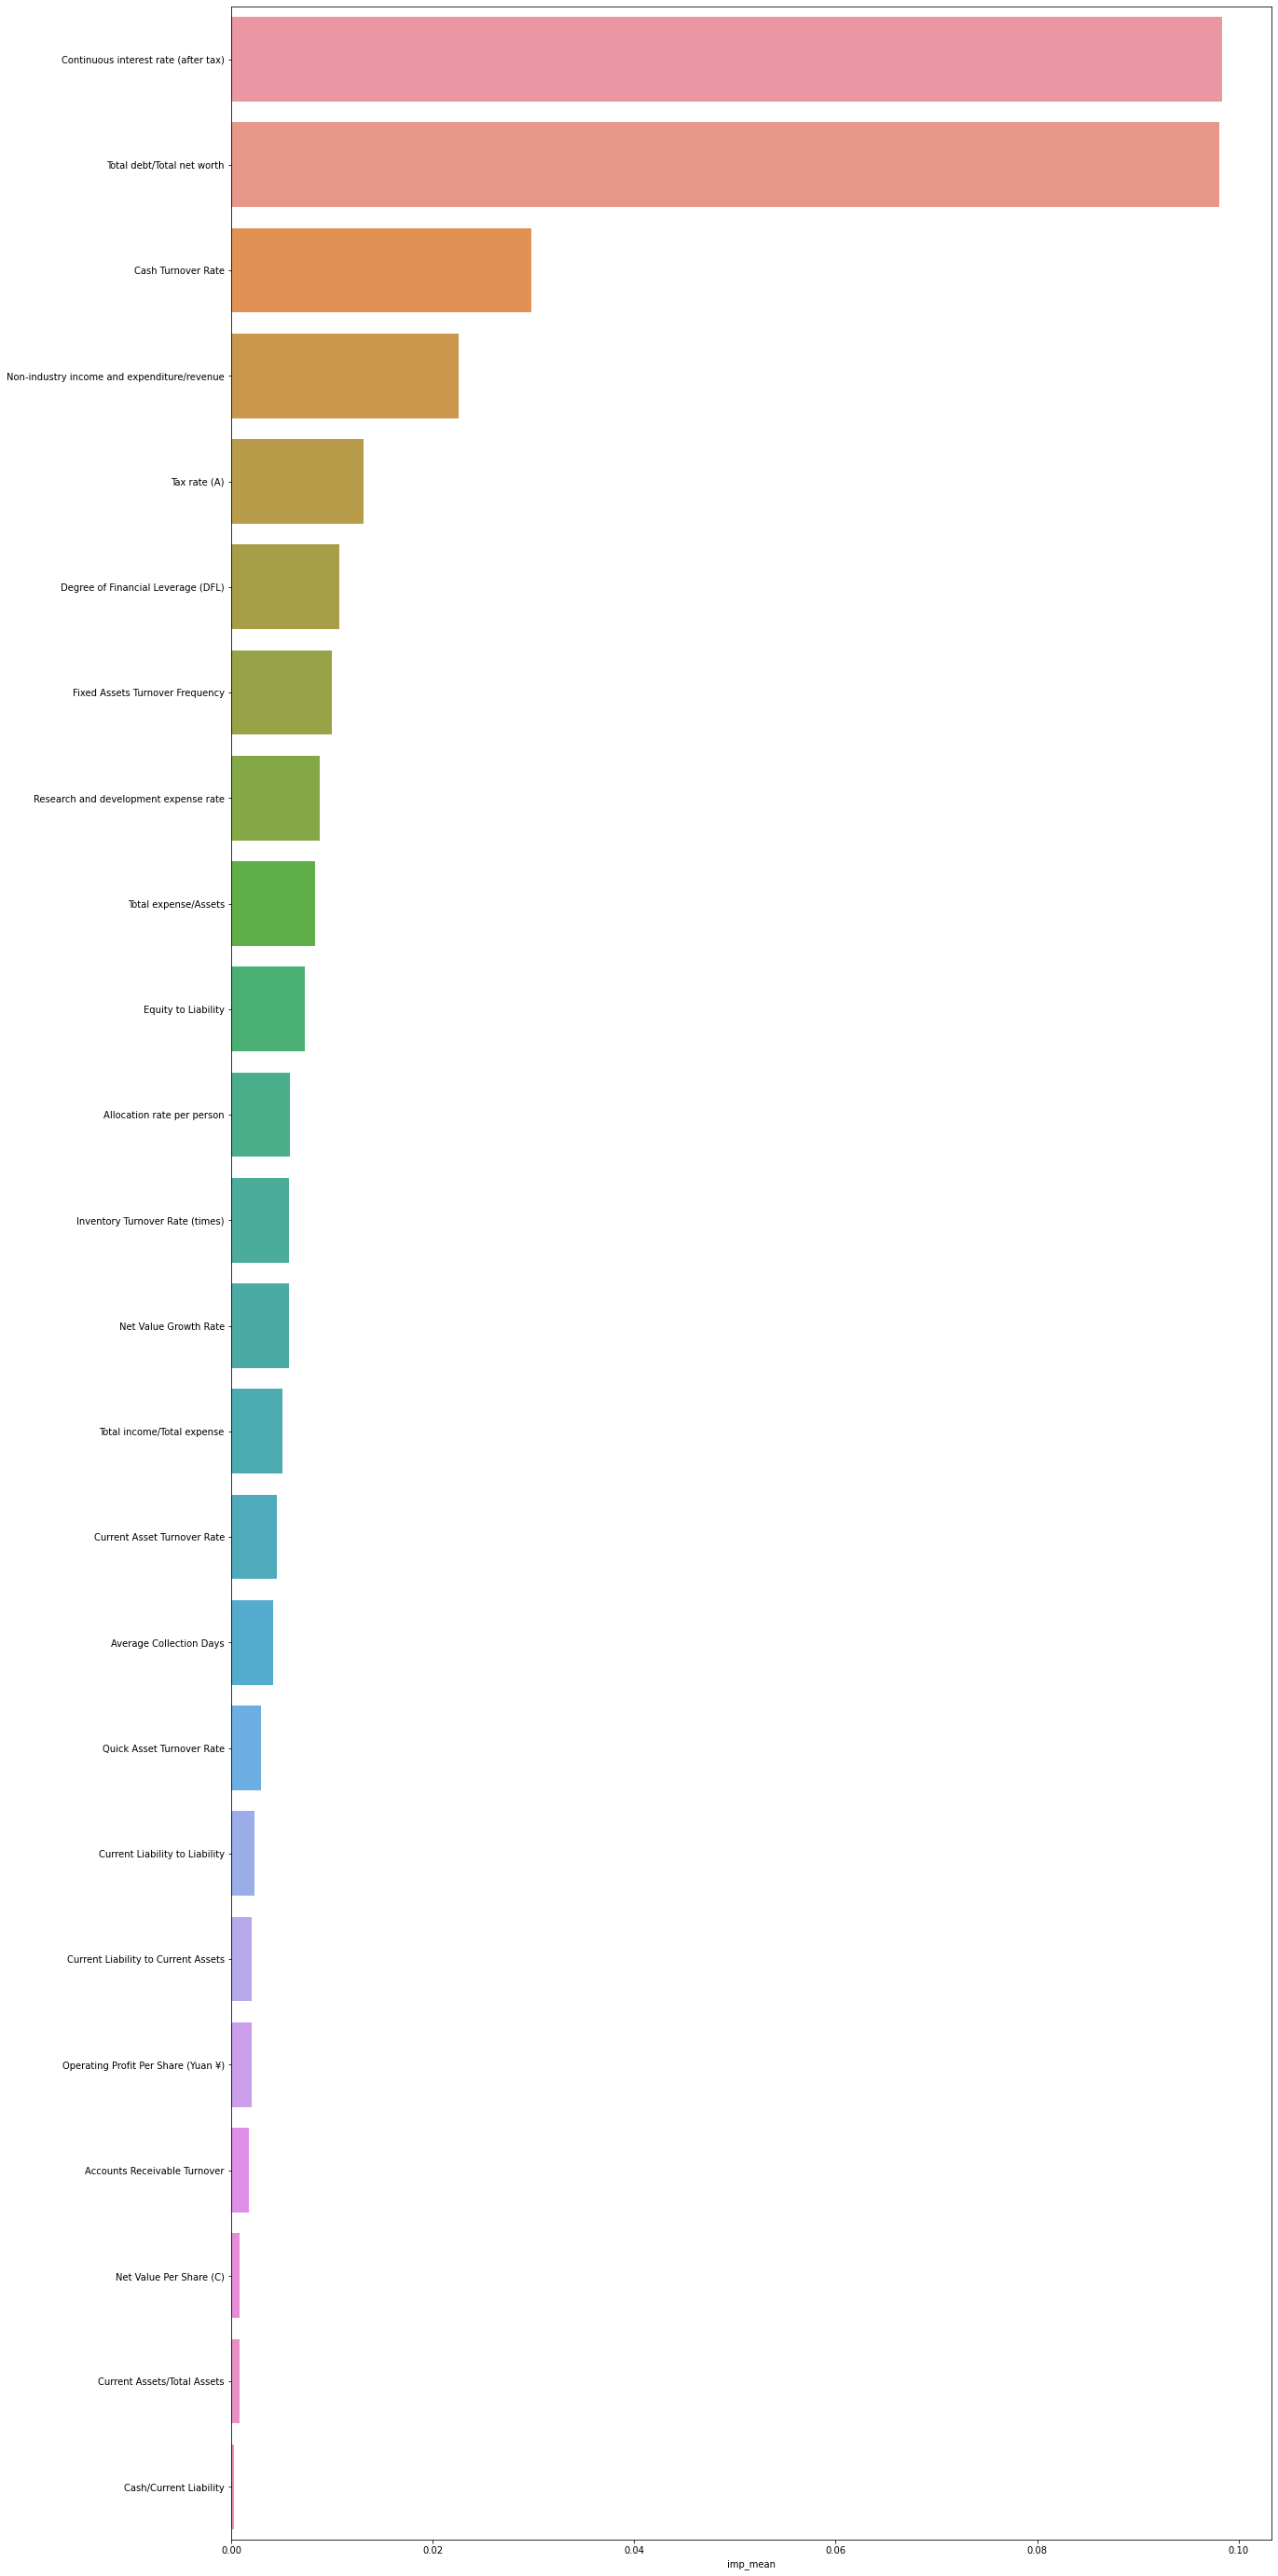

In [113]:
perm_xgb = Permute_Features(best_xgb)
worst_cols_xgb = perm_xgb.loc[ perm_xgb['imp_mean'] <= 0 ]
perm_xgb = perm_xgb.loc[ perm_xgb['imp_mean'] > 0 ]
plt.subplots(figsize=(20,50))
sns.barplot(x=perm_xgb['imp_mean'], y=perm_xgb.index, orient='h');

In [112]:
worst_cols = list(set(worst_cols_xgb.index) & set(worst_cols_rf.index))
if len(worst_cols) > 0:
    print("Drop These Columns in the Wrangle Function:")
    display(worst_cols)
else:
    print("No Unimportant Columns Dectected")

Drop These Columns in the Wrangle Function:


['Realized Sales Gross Profit Growth Rate']